# Line Segment coordinates - TIF file

In [610]:
import rasterio
import matplotlib.pyplot as plt
import csv
import numpy as np
import cv2
import os

## Loading the line segments

In [611]:
def load_line_segments_from_csv(csv_file):
    line_segments = []
    with open(csv_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            fid, start_point, end_point = row
            # Assuming start_point and end_point are in format "x,y"
            start_x, start_y = map(float, start_point.split(','))
            end_x, end_y = map(float, end_point.split(','))
            line_segments.append((start_x, start_y, end_x, end_y))
    return line_segments

In [612]:
lines = load_line_segments_from_csv('Data/csv/dop20rgbi_32_664_5818_2_st_2021.csv')

In [613]:
lines

[(664000.7445959371, 5818271.716671892, 664050.5681964877, 5818216.019557456),
 (664000.9471308987, 5818235.867983691, 664028.8969555977, 5818205.487739451),
 (664000.9471308987, 5818202.247180068, 664008.643459439, 5818192.728036872),
 (664014.3144383633, 5818186.854522989, 664061.3025494516, 5818133.385293129),
 (664033.7577946758, 5818200.424365415, 664078.1129512634, 5818150.803299825),
 (664059.6822697589, 5818207.513089071, 664096.1385628447, 5818164.980747135),
 (664001.3522008215, 5818160.524977981, 664041.2515882545, 5818119.612915741),
 (664000.7445959368, 5818133.587828089, 664025.8589311739, 5818106.650678199),
 (664031.5299100978, 5818393.035113884, 664076.0876016472, 5818333.084765252),
 (664043.6820077931, 5818400.731442425, 664088.6447692658, 5818346.047002793),
 (664062.7202941825, 5818415.313959657, 664110.9236150404, 5818361.034589953),
 (664083.3788602644, 5818431.921826509, 664129.5568315065, 5818380.4779462665),
 (664102.4171466536, 5818449.744903128, 664148.19004

## Converting to pixel coordinates

In [614]:
def get_image_extent_and_pixel_size(image_path):
    with rasterio.open(image_path, 'r') as src:
        width = src.width
        height = src.height
        transform = src.transform

        a, b, c, d, e, f, g, h, i = transform

        # Calculate image extent
        xmin, ymin = transform * (0, 0)
        xmax, ymax = transform * (width, height)

        # Calculate pixel size
        pixel_size_x = a
        pixel_size_y = -e  # Note the negative sign for y

    return (xmin, ymin, xmax, ymax), pixel_size_x, pixel_size_y

In [616]:
img_prop = get_image_extent_and_pixel_size('Data/Data/dop20rgbi_32_664_5818_2_st_2021.tif')

In [617]:
img_prop

((664000.0, 5820000.0, 666000.0, 5818000.0), 0.2, 0.2)

In [618]:
def convert_to_pixel_coordinates(line_segments, image_extent, pixel_size):
    """Converts geographic coordinates to pixel coordinates.

    Args:
        line_segments: List of line segments (x1, y1, x2, y2) in geographic coordinates.
        image_extent: Tuple representing the image extent (xmin, ymin, xmax, ymax).
        pixel_size: Pixel size of the image.

    Returns:
        List of line segments in pixel coordinates (x1, y1, x2, y2).
    """
    pixel_coordinates = []
    for x1, y1, x2, y2 in line_segments:
        pixel_x1 = int((x1 - image_extent[0]) / pixel_size)
        pixel_y1 = int((image_extent[1] - y1) / pixel_size)
        pixel_x2 = int((x2 - image_extent[0]) / pixel_size)
        pixel_y2 = int((image_extent[1] - y2) / pixel_size)
        pixel_coordinates.append((pixel_x1, pixel_y1, pixel_x2, pixel_y2))

    return pixel_coordinates

In [619]:
pixel_coordinates = convert_to_pixel_coordinates(lines, (664000.0, 5820000.0, 666000.0, 5818000.0), 0.2)

In [620]:
# Check for negative values
print(pixel_coordinates)

[(3, 8641, 252, 8919), (4, 8820, 144, 8972), (4, 8988, 43, 9036), (71, 9065, 306, 9333), (168, 8997, 390, 9245), (298, 8962, 480, 9175), (6, 9197, 206, 9401), (3, 9332, 129, 9466), (157, 8034, 380, 8334), (218, 7996, 443, 8269), (313, 7923, 554, 8194), (416, 7840, 647, 8097), (512, 7751, 740, 8030), (566, 8227, 813, 8551), (651, 8160, 931, 8474), (745, 8105, 1010, 8387), (407, 8353, 603, 8666), (455, 8306, 664, 8612), (484, 7723, 159, 7312), (393, 7792, 30, 7329), (47, 4984, 286, 5209), (300, 5223, 472, 5404), (18, 5101, 271, 5316), (295, 5340, 460, 5459), (15, 5280, 173, 5425), (373, 5176, 1042, 4522), (1094, 4589, 808, 4897), (846, 4983, 1156, 4675), (994, 4981, 1230, 4756), (426, 5262, 808, 4897), (14, 4686, 709, 4135), (14, 4440, 511, 4058), (7, 4264, 406, 3972), (14, 4555, 669, 4046), (1125, 67, 1072, 838), (1046, 88, 996, 799), (895, 785, 955, 81), (807, 728, 848, 117), (728, 687, 776, 152), (652, 661, 681, 150), (575, 580, 595, 162), (246, 332, 267, 162), (342, 169, 318, 398), (

In [621]:
def visualize_tile_with_lines(tile_size, line_segments):

  """Plots a list of line segments with the origin at the top-left corner.

  Args:
    line_segments: A list of tuples, where each tuple represents (x1, y1, x2, y2) coordinates of a line segment.
  """

  for x1, y1, x2, y2 in line_segments:
      plt.plot([x1, x2], [y1, y2], color='blue')
    
  plt.xlim(0, 10000)
  plt.ylim(0, 10000)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Line Segments')
  plt.grid(True)
  plt.gca().invert_yaxis()
  plt.show()

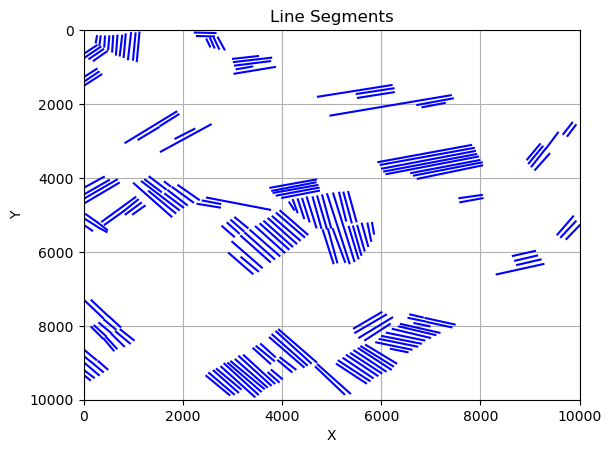

In [622]:
visualize_tile_with_lines(10000, pixel_coordinates)

# Pre-Processing

In [112]:
def dilate_tiff(input_tiff, output_tiff, kernel_size=3):
  with rasterio.open(input_tiff, 'r') as src:
    img = src.read(1)  # Read the first band

  # Convert to OpenCV format
  img_cv = np.uint8(img)

  # Create a dilation kernel
  kernel = np.ones((kernel_size, kernel_size), np.uint8)

  # Apply dilation
  dilated_img = cv2.dilate(img_cv, kernel, iterations=1)

  # Create a new dataset for the dilated image
  with rasterio.open(output_tiff, 'w', **src.meta) as dst:
      dst.write(dilated_img, 1)

In [113]:
input_tiff = os.path.join(os.getcwd(), 'Data/Rasterized/32_664_5818_2_rast_corrected.tif')
output_tiff = 'Data/Dilated_Tif/32_664_5818_2_corrected_dilated.tif'
kernel_size = 16

dilate_tiff(input_tiff, output_tiff, kernel_size)

In [114]:
def split_geotiff(input_file, output_dir, tile_size=512, overlap_fraction=0.25):
    # Assuming the width and height of the image are known or can be obtained through GDAL
    width = 10000  # Example width of the input GeoTIFF (you can extract this via GDAL for real inputs)
    height = 10000  # Example height of the input GeoTIFF
    
    overlap = int(tile_size * overlap_fraction)  # Calculate the overlap, 25% of 512 = 128 pixels
    step_size = tile_size - overlap  # Calculate step size with overlap, 512 - 128 = 384 pixels
    
    # Loop through the input GeoTIFF and extract patches with the specified overlap
    for i in range(0, width - tile_size + 1, step_size):
        for j in range(0, height - tile_size + 1, step_size):
            #output_file = os.path.join(output_dir, f"input_12_{i}_{j}.tif")
            #print(output_file)
            
            # Construct the gdal_translate command with the correct source window (srcwin)
            #gdaltranString = f"gdal_translate -of GTIFF -srcwin {i}, {j}, {tile_size}, {tile_size} {input_file} {output_file}"
            gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(tile_size)+", " \
            +str(tile_size)+" " + input_file + " mask_12_"+str(i)+"_"+str(j)+".tif"
            # Execute the command
            os.system(gdaltranString)
            
            #print(f"Tile generated: {output_file}")

In [115]:
tile_size = 512
dilated_input = os.path.join(os.getcwd(), "Data\Dataset\\dilated\\dilated\\dop20rgbi_32_574_5856_2_ni_2022-05-15_mask.tif")
print(dilated_input)
output_dir = os.path.join(os.getcwd(), "Data\Dataset\extended_train\images")

split_geotiff(dilated_input, output_dir, tile_size)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Dataset\dilated\dilated\dop20rgbi_32_574_5856_2_ni_2022-05-15_mask.tif


# Coordinate Extraction

In [623]:
def clip_line_to_tile(x1, y1, x2, y2, tile_origin_x, tile_origin_y, tile_size):
  """Clips a line segment to a tile.

  Args:
      x1, y1: Start coordinates of the line segment.
      x2, y2: End coordinates of the line segment.
      tile_origin_x: X-coordinate of the tile's origin.
      tile_origin_y: Y-coordinate of the tile's origin.
      tile_size: Size of the tile.

  Returns:
      A list of clipped line segments within the tile.
  """

  tile_xmax = tile_origin_x + tile_size
  tile_ymax = tile_origin_y + tile_size

  # Cohen-Sutherland clipping code
  code1 = compute_code(x1, y1, tile_origin_x, tile_origin_y, tile_xmax, tile_ymax)
  code2 = compute_code(x2, y2, tile_origin_x, tile_origin_y, tile_xmax, tile_ymax)

  accept = 0
  reject = 8
  while True:
      if (code1 | code2) == 0:
          # Both endpoints inside the clip region
          return [(x1, y1, x2, y2)]
      elif (code1 & code2) != 0:
          # Both endpoints outside the clip region
          return []
      else:
          # At least one endpoint is outside the clip region
          outcode = code1 if code1 != 0 else code2
          x, y = clip(x1, y1, x2, y2, outcode, tile_origin_x, tile_origin_y, tile_xmax, tile_ymax)
          if outcode == code1:
              x1, y1 = x, y
              code1 = compute_code(x1, y1, tile_origin_x, tile_origin_y, tile_xmax, tile_ymax)
          else:
              x2, y2 = x, y
              code2 = compute_code(x2, y2, tile_origin_x, tile_origin_y, tile_xmax, tile_ymax)

  return [(x1, y1, x2, y2)]

In [624]:
def compute_code(x, y, xmin, ymin, xmax, ymax):
  code = 0
  if y > ymax:
      code |= 8
  elif y < ymin:
      code |= 4
  if x > xmax:
      code |= 2
  elif x < xmin:
      code |= 1
  return code

def clip(x1, y1, x2, y2, code, xmin, ymin, xmax, ymax):
  if code & 8:
      x = x1 + (x2 - x1) * (ymax - y1) / (y2 - y1)
      y = ymax
  elif code & 4:
      x = x1 + (x2 - x1) * (ymin - y1) / (y2 - y1)
      y = ymin
  elif code & 2:
      y = y1 + (y2 - y1) * (xmax - x1) / (x2 - x1)
      x = xmax
  elif code & 1:
      y = y1 + (y2 - y1) * (xmin - x1) / (x2 - x1)
      x = xmin
  return x, y

In [625]:
def find_intersecting_tiles(x1, y1, x2, y2, tile_size, tile_origins):
    """Finds the tiles that intersect with a given line segment.

    Args:
        x1, y1: Start coordinates of the line segment.
        x2, y2: End coordinates of the line segment.
        tile_size: Size of the tiles.
        tile_origins: List of tile origins (x, y).

    Returns:
        A list of tile indices that intersect the line segment.
    """

    xmin, xmax = min(x1, x2), max(x1, x2)
    ymin, ymax = min(y1, y2), max(y1, y2)

    intersecting_tiles = []
    for tile_index, (tile_origin_x, tile_origin_y) in enumerate(tile_origins):
        if xmin < tile_origin_x + tile_size and xmax >= tile_origin_x and ymin < tile_origin_y + tile_size and ymax >= tile_origin_y:
            intersecting_tiles.append(tile_index)

    return intersecting_tiles

In [626]:
def convert_to_local_coordinates(global_line_segments, tile_origin):
    local_line_segments = []

    for x1, y1, x2, y2 in global_line_segments:
        local_x1 = x1 - tile_origin[0]
        local_y1 = y1 - tile_origin[1]
        local_x2 = x2 - tile_origin[0]
        local_y2 = y2 - tile_origin[1]
        local_line_segments.append((local_x1, local_y1, local_x2, local_y2))

    return local_line_segments

In [627]:
def map_line_segments_to_files(line_segments, tile_size, tile_origins):
    """Maps line segments to files.

    Args:
        line_segments: List of line segments (x1, y1, x2, y2) in the original image.
        tile_size: Size of the tiles.
        tile_origins: List of tile origins (x, y).
    """

    tile_line_segments = {}

    for line_index, line in enumerate(line_segments):
        x1, y1, x2, y2 = line

        # Find intersecting tiles
        intersecting_tiles = find_intersecting_tiles(x1, y1, x2, y2, tile_size, tile_origins)

        for tile_index in intersecting_tiles:
            tile_origin_x, tile_origin_y = tile_origins[tile_index]
            clipped_lines = clip_line_to_tile(x1, y1, x2, y2, tile_origin_x, tile_origin_y, tile_size)
            conv_coordinates = convert_to_local_coordinates(clipped_lines, [tile_origin_x, tile_origin_y])

            tile_line_segments.setdefault(tile_index, []).extend(conv_coordinates)

    # Create empty files for tiles without line segments
    for tile_index, tile_origin in enumerate(tile_origins):
        if tile_index not in tile_line_segments:
            filename = f"Coo_11_{tile_origin[0]}_{tile_origin[1]}_coo.txt"
            filepath = os.path.join(os.getcwd(), 'Data\\line_coord\\tile_11', filename)
            with open(filepath, 'w') as f:
                pass  # Create an empty file

    # Write line segments to their respective files
    for tile_index, lines in tile_line_segments.items():
        filename = f"Coo_11_{tile_origins[tile_index][0]}_{tile_origins[tile_index][1]}_coo.txt"
        filepath = os.path.join(os.getcwd(), 'Data\\line_coord\\tile_11', filename)

        with open(filepath, 'a') as f:
            for coord in lines:
                line = ', '.join(str(value) for value in coord)
                f.write(line + '\n')

In [629]:
tiles_path = 'Data\\tiles\\tiles_10'

tile_origins = []

for file in os.listdir(tiles_path):
    # Remove the extension
    basename = file.replace('.tif', '')
    #filename_without_ext = os.path.splitext(file)[0]
    
    # Split the filename by '_'
    parts = basename.split('_')
    
    # Extract the values
    x, y = int(parts[2]), int(parts[3])

    tile_origins.append((x, y))

In [630]:
map_line_segments_to_files(pixel_coordinates , 512, tile_origins)

In [35]:
def plot_line_segments(line_segments):
  """Plots a list of line segments with the origin at the top-left corner.

  Args:
    line_segments: A list of tuples, where each tuple represents (x1, y1, x2, y2) coordinates of a line segment.
  """

  for x1, y1, x2, y2 in line_segments:
    plt.plot([x1, x2], [y1, y2], color='blue')

  plt.xlim(0, 512)
  plt.ylim(0, 512)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Line Segments')
  plt.grid(True)
  plt.gca().invert_yaxis()
  plt.show()


In [36]:
coord_file = "Data/Tile_Line_Coo_2/output_1536_4224_coo.txt"

read_coordinates = []
with open(coord_file, 'r') as f:
    for line in f:
      values = line.strip().split(',')
      if values:  # Check if the line is not empty
        try:
          read_coordinates.append(tuple(float(value) for value in values))
        except ValueError:
          print(f"Error parsing line: {line}")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Tile_Line_Coo_2/output_1536_4224_coo.txt'

In [ ]:
read_coordinates

In [ ]:
plot_line_segments(read_coordinates)

# Random Testing

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage.transform import probabilistic_hough_line

In [ ]:
img = cv2.imread('Data/Img_tif/output_3072_6656.tif')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
cv2.imshow('Image using OpenCV', img)
cv2.waitKey(0)
cv2.destroyAllWindows

In [ ]:
plt.imshow(image_rgb)
plt.title('Image using Matplotlib')
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
print("Image shape:", img.shape)

In [ ]:
if img.shape[-1] == 4:
    # Assuming the channels are in the order: Red, Green, Blue, Infrared
    red_channel = img[:, :, 0]
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]
    infrared_channel = img[:, :, 3]

    # Stack only the RGB channels
    rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

    # Alternatively, reorder channels to match expected RGB (not BGR)
    rgb_image = cv2.merge((red_channel, green_channel, blue_channel))
else:
    print("The image does not have 4 channels.")

cv2.imshow("RGB Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
img_1 = cv2.imread('Data/output_1536_6656.png', cv2.I)

In [ ]:
plt.imshow(img_1)

In [ ]:
img_1.shape

In [ ]:
msk = cv2.imread('Data/Tiles_Tif/output_0_7168.tif', cv2.IMREAD_ANYDEPTH)

In [ ]:
msk

In [ ]:
plt.imshow(msk)

In [ ]:
msk.max()

In [ ]:
mask_uint8 = msk.astype(np.uint8)

In [ ]:
mask_uint8

In [ ]:
plt.imshow(mask_uint8)

In [ ]:
mask_uint8.max()

In [ ]:
pred_mask = cv2.imread('Data/Misc/pred_mask_1.png')

gray_image = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(gray_image)

In [ ]:
image_uint8 = gray_image.astype(np.uint8)

print(image_uint8.shape)

In [ ]:
edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()

In [ ]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours onto a new image
lines = np.zeros_like(image_uint8)
cv2.drawContours(lines, contours, -1, (255), 1)

In [ ]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(lines, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

In [ ]:
# Define a kernel
kernel = np.ones((18,18), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(lines, kernel, iterations=1)

binary_image = dilated_edges // 255

skeleton = skeletonize(dilated_edges)

In [ ]:
plt.imshow(skeleton, cmap='gray')  # Display in grayscale
plt.title('Closed Edges')  # Optional: Title for the plot
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [ ]:
lines = probabilistic_hough_line(skeleton, threshold=20, line_length=1, line_gap=10)

In [ ]:
len(lines)

In [ ]:
if lines is not None:
    for line in lines:
        (x1, y1), (x2, y2) = line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the line in green

cv2.imshow('Probabilistic Hough Transform', line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Removing Dummies

In [4]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
import torch

In [5]:
curr_path = os.getcwd()
print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [6]:
src_dir = os.path.join(curr_path, 'Data\Dataset\extended_train\masks')
print(src_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Dataset\extended_train\masks


In [9]:
dest_dir = os.path.join(curr_path, 'Data\Dataset\\extended_train\\reduced_masks')
print(dest_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Dataset\extended_train\reduced_masks


In [10]:
masks = os.listdir(src_dir)
print(masks)

['mask_12_0_0.tif', 'mask_12_0_1152.tif', 'mask_12_0_1536.tif', 'mask_12_0_1920.tif', 'mask_12_0_2304.tif', 'mask_12_0_2688.tif', 'mask_12_0_3072.tif', 'mask_12_0_3456.tif', 'mask_12_0_384.tif', 'mask_12_0_3840.tif', 'mask_12_0_4224.tif', 'mask_12_0_4608.tif', 'mask_12_0_4992.tif', 'mask_12_0_5376.tif', 'mask_12_0_5760.tif', 'mask_12_0_6144.tif', 'mask_12_0_6528.tif', 'mask_12_0_6912.tif', 'mask_12_0_7296.tif', 'mask_12_0_768.tif', 'mask_12_0_7680.tif', 'mask_12_0_8064.tif', 'mask_12_0_8448.tif', 'mask_12_0_8832.tif', 'mask_12_0_9216.tif', 'mask_12_1152_0.tif', 'mask_12_1152_1152.tif', 'mask_12_1152_1536.tif', 'mask_12_1152_1920.tif', 'mask_12_1152_2304.tif', 'mask_12_1152_2688.tif', 'mask_12_1152_3072.tif', 'mask_12_1152_3456.tif', 'mask_12_1152_384.tif', 'mask_12_1152_3840.tif', 'mask_12_1152_4224.tif', 'mask_12_1152_4608.tif', 'mask_12_1152_4992.tif', 'mask_12_1152_5376.tif', 'mask_12_1152_5760.tif', 'mask_12_1152_6144.tif', 'mask_12_1152_6528.tif', 'mask_12_1152_6912.tif', 'mask_12

In [11]:
for mask_name in masks:
    src_file_path = os.path.join(src_dir, mask_name)
    with rasterio.open(src_file_path) as src:
        data = src.read(1)

        if (data > 0).any():
            dest_file_path = os.path.join(dest_dir, mask_name)
            shutil.copy(src_file_path, dest_file_path)

In [13]:
blank_images = []

for mask_name in masks:
    src_file_path = os.path.join(src_dir, mask_name)
    with rasterio.open(src_file_path) as src:
        data = src.read(1)

    if not np.any(data > 0):
        blank_images.append(src_file_path)

In [14]:
len(blank_images)

4306

In [15]:
selected_images = random.sample(blank_images, 200)

for src_file_path in selected_images:
    file_name = os.path.basename(src_file_path)
    dest_file_path = os.path.join(dest_dir, file_name)
    shutil.copy(src_file_path, dest_file_path)

In [16]:
train_mask_path = os.path.join(curr_path, 'Data\Dataset\\extended_train\\reduced_masks')
train_masks = os.listdir(train_mask_path)

In [17]:
len(train_masks)

4644

In [18]:
all_tile_path = os.path.join(curr_path, 'Data\Dataset\\extended_train\\images')
train_tile_path = os.path.join(curr_path, 'Data\\Dataset\\extended_train\\reduced_images')

for mask_file in train_masks:
    base_name = mask_file[len("mask_"):].replace(".tif", "")
    input_file = f"input_{base_name}.tif"
    src_path = os.path.join(all_tile_path, input_file)
    dest_path = os.path.join(train_tile_path, input_file)
    shutil.copy(src_path, dest_path) 

In [ ]:
train_path = os.path.join(curr_path, 'Data\\Dataset\\train\\tiles\\input_1_0_5760.tif')
print(train_path)

In [ ]:
with rasterio.open(train_path) as src:
    image = src.read([1, 2, 3])
    image_float = image.astype(np.float32)
    
    # Normalize to range [0, 1]
    image_normalized = image_float / 255.0
    print(image_normalized)
    print(type(image_normalized))
    
    image_tensor = torch.from_numpy(image_normalized).float()

In [ ]:
train_mask = os.path.join(curr_path, 'Data\\Dataset\\train\\masks\\mask_1_0_5760.tif')
print(train_mask)

In [ ]:
with rasterio.open(train_mask) as src:
    mask = src.read([1])
    print(np.min(mask))
    print(type(mask))